# Bayesian Analysis Using PyMC3

Before we jump in to model-building and using MCMC to do wonderful things, it is useful to understand a few of the theoretical underpinnings of the Bayesian statistical paradigm. A little theory (and I do mean a *little*) goes a long way towards being able to apply the methods correctly and effectively.

## What *is* Bayesian Statistical Analysis?

Though many of you will have taken a statistics course or two during your undergraduate (or graduate) education, most of those who have will likely not have had a course in *Bayesian* statistics. Most introductory courses, particularly for non-statisticians, still do not cover Bayesian methods at all, except perhaps to derive Bayes' formula as a trivial rearrangement of the definition of conditional probability. Even today, Bayesian courses are typically tacked onto the curriculum, rather than being integrated into the program.

In fact, Bayesian statistics is not just a particular method, or even a class of methods; it is an entirely different paradigm for doing statistical analysis.

> Practical methods for making inferences from data using probability models for quantities we observe and about which we wish to learn.
*-- Gelman et al. 2013*

A Bayesian model is described by parameters, uncertainty in those parameters is described using probability distributions.

All conclusions from Bayesian statistical procedures are stated in terms of *probability statements*

![](images/prob_model.png)

This confers several benefits to the analyst, including:

- ease of interpretation, summarization of uncertainty
- can incorporate uncertainty in parent parameters
- easy to calculate summary statistics

## Bayesian vs Frequentist Statistics: What's the difference?

Any statistical paradigm, Bayesian or otherwise, involves at least the following: 

1. Some **unknown quantities** about which we are interested in learning or testing. We call these *parameters*.
2. Some **data** which have been observed, and hopefully contain information about (1).
3. One or more **models** that relate the data to the parameters, and is the instrument that is used to learn.

### The Frequentist World View

![Fisher](images/fisher.png)

- The data that have been observed are considered **random**, because they are realizations of random processes, and hence will vary each time one goes to observe the system.
- Model parameters are considered **fixed**. The parameters' values are unknown, but they are fixed, and so we *condition* on them.

In mathematical notation, this implies a (very) general model of the following form:

<div style="font-size:35px">
\\[f(y | \theta)\\]
</div>

Here, the model \\(f\\) accepts data values \\(y\\) as an argument, conditional on particular values of \\(\theta\\).

Frequentist inference typically involves deriving **estimators** for the unknown parameters. Estimators are formulae that return estimates for particular estimands, as a function of data. They are selected based on some chosen optimality criterion, such as *unbiasedness*, *variance minimization*, or *efficiency*.

> For example, lets say that we have collected some data on the prevalence of autism spectrum disorder (ASD) in some defined population. Our sample includes \\(n\\) sampled children, \\(y\\) of them having been diagnosed with autism. A frequentist estimator of the prevalence \\(p\\) is:

> <div style="font-size:25px">
> \\[\hat{p} = \frac{y}{n}\\]
> </div>

> Why this particular function? Because it can be shown to be unbiased and minimum-variance.

It is important to note that new estimators need to be derived for every estimand that is introduced.

### The Bayesian World View

![Bayes](images/bayes.png)

- Data are considered **fixed**. They used to be random, but once they were written into your lab notebook/spreadsheet/IPython notebook they do not change.
- Model parameters themselves may not be random, but Bayesians use probability distribtutions to describe their uncertainty in parameter values, and are therefore treated as **random**. In some cases, it is useful to consider parameters as having been sampled from probability distributions.

This implies the following form:

<div style="font-size:35px">
\\[p(\theta | y)\\]
</div>

This formulation used to be referred to as ***inverse probability***, because it infers from observations to parameters, or from effects to causes.

Bayesians do not seek new estimators for every estimation problem they encounter. There is only one estimator for Bayesian inference: **Bayes' Formula**.

![](images/bayes_formula.png)

## Example: Statistical hypothesis testing

The *de facto* standard for statistical inference is statistical hypothesis testing. The goal of hypothesis testing is to evaluate a **null hypothesis**. There are two possible outcomes:

- reject the null hypothesis
- fail to reject the null hypothesis

Rejection occurs when a chosen test statistic is higher than some pre-specified threshold valuel; non-rejection occurs otherwise.

Notice that neither outcome says anything about the quantity of interest, the **research hypothesis**. 

Setting up a statistical test involves several subjective choices by the user that are rarely justified based on the problem or decision at hand:

- statistical test to use
- null hypothesis to test
- significance level

Choices are often based on arbitrary criteria, including "statistical tradition" (Johnson 1999). The resulting evidence is indirect, incomplete, and typically overstates the evidence against the null hypothesis (Goodman 1999).

Most importantly to applied users, the results of statistical hypothesis tests are very easy to misinterpret. 

### Estimation 

Instead of testing, a more informative and effective approach for inference is based on **estimation** (be it frequentist or Bayesian). That is, rather than testing whether two groups are different, we instead pursue an estimate of *how different* they are, which is fundamentally more informative. 

Additionally, we include an estimate of **uncertainty** associated with that difference which includes uncertainty due to our lack of knowledge of the model parameters (*epistemic uncertainty*) and uncertainty due to the inherent stochasticity of the system (*aleatory uncertainty*).

### Case Study: Radon contamination

As a simple example, we will conduct an analysis using Gelman et al.'s (2007) radon dataset. In this dataset the amount of the radioactive gas radon has been measured among different households in all counties of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil.

>  the US EPA has set an action level of 4 pCi/L. At or above this level of radon, the EPA recommends you take corrective measures to reduce your exposure to radon gas.

![radon](images/how_radon_enters.jpg)

Let's import the dataset:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

import warnings
warnings.filterwarnings("ignore")

In [2]:
radon = pd.read_csv('../data/radon.csv', index_col=0)
radon.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


Let's focus on the (log) radon levels measured in a single county (Hennepin). 

Suppose we are interested in:

- whether the mean radon value is greater than 4 pCi/L in Hennepin county
- the probability that any randomly-chosen household in Hennepin county has a reading of greater than 4

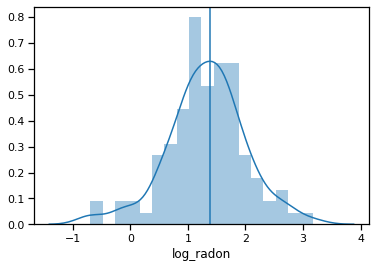

In [3]:
hennepin_radon = radon.query('county=="HENNEPIN"').log_radon
sns.distplot(hennepin_radon, bins=18)
plt.axvline(np.log(4));

## The Bayesian Workflow

The process of conducting Bayesian inference can be broken down into three general steps (Gelman *et al.* 2013):

![](images/123.png)

### Step 1: Specify a probability model

As was noted above, Bayesian statistics involves using probability models to solve problems. So, the first task is to *completely specify* the model in terms of probability distributions. This includes everything: unknown parameters, data, covariates, missing data, predictions. All must be assigned some probability density.

This step involves making choices.

- what is the form of the sampling distribution of the data?
- what form best describes our uncertainty in the unknown parameters?

### Step 2: Calculate a posterior distribution

The mathematical form \\(p(\theta | y)\\) that we associated with the Bayesian approach is referred to as a **posterior distribution**.

> posterior /pos·ter·i·or/ (pos-tēr´e-er) later in time; subsequent.

Why posterior? Because it tells us what we know about the unknown \\(\theta\\) *after* having observed \\(y\\).

This posterior distribution is formulated as a function of the probability model that was specified in Step 1. Usually, we can write it down but we cannot calculate it analytically. In fact, the difficulty inherent in calculating the posterior distribution for most models of interest is perhaps the major contributing factor for the lack of widespread adoption of Bayesian methods for data analysis. Various strategies for doing so comprise this tutorial.

**But**, once the posterior distribution is calculated, you get a lot for free:

- point estimates
- credible intervals
- quantiles
- predictions

### Step 3: Check your model

Though frequently ignored in practice, it is critical that the model and its outputs be assessed before using the outputs for inference. Models are specified based on assumptions that are largely unverifiable, so the least we can do is examine the output in detail, relative to the specified model and the data that were used to fit the model.

Specifically, we must ask:

- does the model fit data?
- are the conclusions reasonable?
- are the outputs sensitive to changes in model structure?

### Probability Model

Returning to our example, specifying a full probability model consists of:

- a likelihood function(s) for the observations
- priors for the unknown parameters of the model

The measurements look approximately normal, so let's start by assuming a normal distribution as the sampling distribution (likelihood) for the data. 

$$y_i \sim N(\mu, \sigma^2)$$

(don't worry, we can evaluate this assumption)

This implies that we have 2 unknowns in the model; the mean and standard deviation of the distribution. 

#### Prior choice

How do we choose distributions to use as priors for these parameters? 

There are several considerations:

- discrete vs continuous values
- the support of the variable
- the available prior information

While there may likely be prior information about the distribution of radon values, we will assume no prior knowledge, and specify a **diffuse** prior for each parameter.

Since the mean can take any real value (since it is on the log scale), we will use another normal distribution here, and specify a large variance to allow the possibility of very large or very small values:

$$\mu \sim N(0, 10^2)$$

For the standard deviation, we know that the true value must be positive (no negative variances!). I will choose a uniform prior bounded from below at zero and from above at a value that is sure to be higher than any plausible value the true standard deviation (on the log scale) could take.

$$\sigma \sim U(0, 10)$$

We can encode these in a Python model, using PyMC3 as follows:

In [4]:
from pymc3 import Model, Normal, Uniform

with Model() as radon_model:
    
    μ = Normal('μ', mu=0, sd=10)
    σ = Uniform('σ', 0, 10)

All that remains is to add the likelihood, which takes $\mu$ and $\sigma$ as parameters, and the log-radon values as the set of observations:

In [5]:
with radon_model:
    
    dist = Normal('dist', mu=μ, sd=σ, observed=hennepin_radon)

Now, we will fit the model using a numerical approach called **Markov chain Monte Carlo (MCMC)**. This will draw samples from the posterior distribution (which cannot be calculated exactly).

In [6]:
from pymc3 import sample

with radon_model:
    
    samples = sample(1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 752.45draws/s]


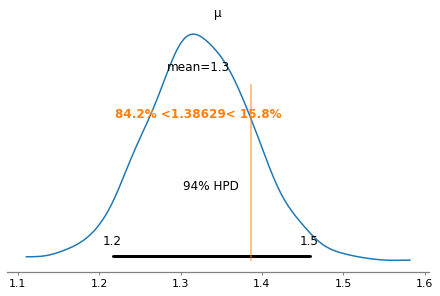

In [7]:
from arviz import plot_posterior

plot_posterior(samples, var_names=['μ'], ref_val=np.log(4));

The plot shows the posterior distribution of $\mu$, along with an estimate of the 95% posterior **credible interval**. 

The output

    83% < 1.38629 < 17%
    
informs us that the probability of $\mu$ being less than log(4) is 83% and the corresponding probability of being greater than log(4) is 17%.

> The posterior probability that the mean level of household radon in Henneprin County is greater than 4 pCi/L is 0.17.

### Prediction

What is the probability that a given household has a log-radon measurement larger than one? To answer this, we make use of the **posterior predictive distribution**.

$$p(z |y) = \int_{\theta} p(z |\theta) p(\theta | y) d\theta$$

where here $z$ is the predicted value and y is the data used to fit the model.

We can estimate this from the posterior samples of the parameters in the model.

In [8]:
mus = samples['μ']
sigmas = samples['σ']

In [9]:
radon_samples = Normal.dist(mus, sigmas).random()

In [10]:
(radon_samples > np.log(4)).mean()

0.4795

> The posterior probability that a randomly-selected household in Henneprin County contains radon levels in excess of 4 pCi/L is ~0.47.

### Model checking

But, ***how do we know this model is any good?***

Its important to check the fit of the model, to see if its assumptions are reasonable. One way to do this is to perform **posterior predictive checks**. This involves generating simulated data using the model that you built, and comparing that data to the observed data.

One can choose a particular statistic to compare, such as tail probabilities or quartiles, but here it is useful to compare them graphically.

We already have these simulations from the previous exercise!

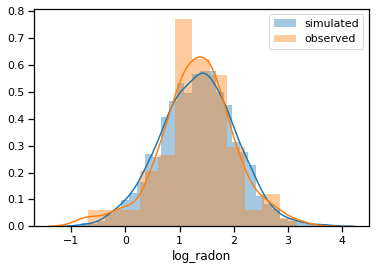

In [11]:
sns.distplot(radon_samples, label='simulated')
sns.distplot(hennepin_radon, label='observed')
plt.legend();

### Prior sensitivity

Its also important to check the sensitivity of your choice of priors to the resulting inference.

Here is the same model, but with drastically different (though still uninformative) priors specified:

In [12]:
from pymc3 import Flat, HalfCauchy

with Model() as prior_sensitivity:
    
    μ = Flat('μ')
    σ = HalfCauchy('σ', 5)
    
    dist = Normal('dist', mu=μ, sd=σ, observed=hennepin_radon)
    
    sensitivity_samples = sample(1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 796.36draws/s]


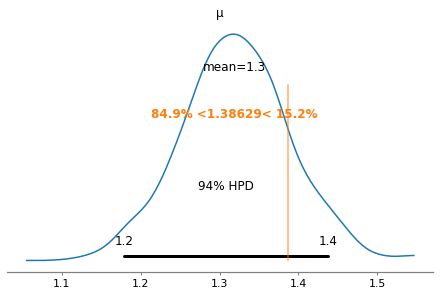

In [13]:
plot_posterior(sensitivity_samples, var_names=['μ'], ref_val=np.log(4));

Here is the original model for comparison:

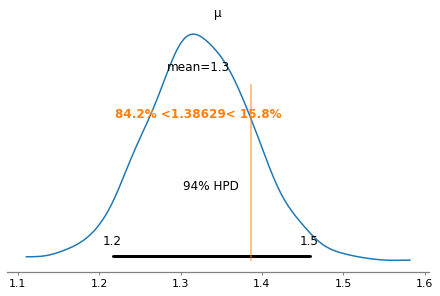

In [14]:
plot_posterior(samples, var_names=['μ'], ref_val=np.log(4));

---
## To Learn More

- Kruschke, J.K. [Doing Bayesian Data Analysis, Second Edition: A Tutorial with R, JAGS, and Stan](https://www.amazon.com/Doing-Bayesian-Data-Analysis-Tutorial/dp/0124058884). 2015. Academic Press / Elsevier. 
- [Probabilistic Programming and Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) by Cam Davidson Pilon
- [PyMC3 Tutorial Notebooks](https://docs.pymc.io/nb_tutorials/index.html)